# Calculate Von Neumann Entropy and Purity for Dicke-Basis density matrix in presence of homogeneous local dissipation

Author: Nathan Shammah, nathan.shammah@gmail.com

We provide a tutorial for the task of calculating nonlinear functions of the denisty matrix, such as the Von Neumann entropy and purity, using the Dicke-Basis formalism in an open Lindblad dynamics characterized by (collective and) homogeneous local incoherent processes [1,2].

For an introduction to the `qutip.piqs` module, see [The Introductory Notebook](https://nbviewer.jupyter.org/github/qutip/qutip-notebooks/blob/master/examples/piqs-overview.ipynb) or see Ref. [1].

We provide an example of three bases that can be used the dynamics of a spin system on a lattice with all-to-all connectivity or of an ensemble of two-level systems in cavity QED. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from qutip import *
from qutip.piqs import *
from scipy.sparse import block_diag
from scipy.sparse.linalg import eigsh, eigs
from scipy import log

### Define some auxiliary functions

In [2]:
def plot_rho(rho, title=None):
    """
    Plot the image show of the real values of a Qobj operator.
    
    Input:
    ------
    rho : :class: qutip.Qobj
        Density matrix or operator.
    Returns:
    ------
    figure : matplotlib.pyplot.figure
        Figure showing real part of matrix elements of the density matrix.
    """    
    plt.figure()
    plt.imshow(np.real(rho.full()))
    if title is not None:
        plt.title(title)
    plt.show()

In [3]:
def spin_hamiltonian(N,h,basis="jmat"):
    """
    Calculate generalized spin Hamiltonian in the `jmat`, `dicke` or `uncoupled` basis.
    
    Input:
    ------
    N : int
        Number of spins.
    h : float
        Magnitude of transverse (Jx) external magnetic field, of size (N+1).
    basis : string, (default='jmat')
        Basis of the Hamiltonian. 
        Can be 'jmat' (N+1), 'dicke' (O(N^2)), or "uncoupled" (2^N).                
    Returns:
    ------
    hamiltonian_spin : qutip.Qobj()
        Hamiltonian of the system in the given basis (default is `jmat`).
    """
    if basis=="jmat":
        jx,jy,jz = jmat(N/2)
    elif basis=="dicke":
        jx,jy,jz = jspin(N, basis="dicke")
    elif basis=="uncoupled":
        jx,jy,jz = jspin(N, basis="uncoupled")
    
    hamiltonian_spin = (jz**2)-h*jx
    return hamiltonian_spin

### Visualizing the density matrix structure

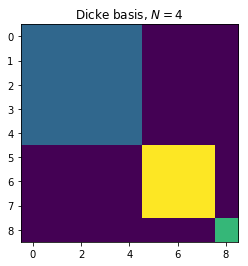

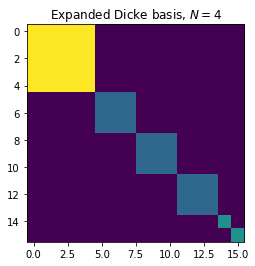

In [4]:
N = 4
# Compact Dicke basis (O(N^3))
rho_dicke = Qobj(block_matrix(N,elements="degeneracy"))
plot_rho(rho_dicke, title='Dicke basis, $N={}$'.format(N))
# Expanded Dicke basis (2^N)
expanded_dicke_blocks = dicke_blocks_full(Qobj(block_matrix(N,elements="ones")))
rho_dicke_extended = Qobj(block_diag(expanded_dicke_blocks))
plot_rho(rho_dicke_extended, title='Expanded Dicke basis, $N={}$'.format(N))

In the color plots above, we show the crucial difference between the representative of the density matrix in the Dicke basis used by `qutip.piqs` (top panel) and the expanded object, which is the actual density matrix with all the degenerate blocks. All the information on the density matrix is contained already in the compact representative density matrix, which can be used to derive the dynamics, but in order to correctly calculate nonlinear properties of the density matrix, in presence of homogenous local processes, one needs to properly account for the non-symmetrical degenerate blocks, as shown below.  

### Defining the all-to-all spin Hamiltonian

In [5]:
# define the spin Hamiltonian
h = 0.1
H = spin_hamiltonian(N,h)

In [6]:
h_jmat = spin_hamiltonian(N,h,basis="jmat")
h_uncoupled = spin_hamiltonian(N,h,basis="uncoupled")
h_dicke = spin_hamiltonian(N,h,basis="dicke")
eigvals_dicke, eigvecs_dicke = h_dicke.eigenstates()
eigvals_uncoupled, eigvecs_uncoupled = h_uncoupled.eigenstates()
eigvals_jmat, eigvecs_jmat = h_jmat.eigenstates()

In [7]:
# spin operators
jx_jmat,jy_jmat,jz_jmat = jmat(N/2)
jm_jmat = jmat(N/2,"-")
jx_dicke,jy_dicke,jz_dicke = jspin(N, basis="dicke")
jm_dicke = jspin(N, "-",basis="dicke")
jx_uncoupled,jy_uncoupled,jz_uncoupled = jspin(N, basis="uncoupled")
jm_uncoupled = jspin(N, "-",basis="uncoupled")

In [8]:
excited_dicke = excited(N,basis="dicke")
excited_uncoupled = excited(N,basis="uncoupled")
rho0_dicke = excited_dicke
rho0_uncoupled = excited_uncoupled

In [9]:
# create local operators (0.5*Pauli matrices)
sx_list, sy_list, sz_list = spin_algebra(N)
sm_list = []
sp_list = []
for i in range(0,len(sx_list)):
    sm_list.append(sx_list[i] - 1j*sy_list[i])
    sp_list.append(sx_list[i] + 1j*sy_list[i])
jp_uncoupled = jm_uncoupled.dag()

### Defining the dissipation rates and building the Liouvillian superoperator

In [10]:
# rates of local and collective incoherent processes 
gamma_local_down = 0.05 
gamma_local_up = 0.3*gamma_local_down
gamma_local_phi = np.pi*gamma_local_down
# create local collapse operators
# full space (2^N Hilbert space, uncoupled basis)
c_ops_local = []
for i in range(0,len(sx_list)):
    c_ops_local.append(np.sqrt(gamma_local_down)*sm_list[i])
    c_ops_local.append(np.sqrt(gamma_local_up)*sm_list[i].dag())
    c_ops_local.append(np.sqrt(gamma_local_phi)*sz_list[i])
# Dicke space (N^2 Hilbert space for the density matrix, coupled basis)
ensemble = Dicke(N)
ensemble.hamiltonian = h_dicke
ensemble.emission = gamma_local_down
ensemble.pumping = gamma_local_up
ensemble.dephasing = gamma_local_phi
#ensemble.collective_emission = gamma_local_down
print(ensemble)
liouvillian_local_dicke = ensemble.liouvillian()
liouvillian_local_uncoupled = liouvillian(0*h_uncoupled,c_ops=c_ops_local)

N = 4
Hilbert space dim = (9, 9)
Number of Dicke states = 9
Liouvillian space dim = (81, 81)
emission = 0.05
dephasing = 0.15707963267948966
pumping = 0.015


### Solving the time evolution of the Lindblad master equation

In [11]:
# time 
times = np.linspace(0,50,500)
## local dissipation only 
storing = Options(store_states=True)
store = True
# Dicke
result_local_dicke = mesolve(liouvillian_local_dicke,rho0_dicke,times, 
                       c_ops=[],      
                       e_ops=[jx_dicke,jy_dicke,jz_dicke,
                              jx_dicke**2,jy_dicke**2, 
                              jz_dicke**2,jm_dicke.dag()],
                            options=storing)
jxt_local_dicke = result_local_dicke.expect[0]
jyt_local_dicke = result_local_dicke.expect[1]
jzt_local_dicke = result_local_dicke.expect[2]
jxxt_local_dicke = result_local_dicke.expect[3]
jyyt_local_dicke = result_local_dicke.expect[4]
jzzt_local_dicke = result_local_dicke.expect[5]
jpt_local_dicke = result_local_dicke.expect[6]
if store == True:
    rhot_local_dicke = result_local_dicke.states
print("Dicke local ok")
# full
result_local_uncoupled = mesolve(h_uncoupled,rho0_uncoupled,times, 
                           c_ops=c_ops_local,
                           e_ops=[jx_uncoupled,jy_uncoupled,jz_uncoupled,
                                  jx_uncoupled**2,jy_uncoupled**2, 
                                 jz_uncoupled**2,
                                 jp_uncoupled],
                                options=storing)
jxt_local_uncoupled = result_local_uncoupled.expect[0]
jyt_local_uncoupled = result_local_uncoupled.expect[1]
jzt_local_uncoupled = result_local_uncoupled.expect[2]
jxxt_local_uncoupled = result_local_uncoupled.expect[3]
jyyt_local_uncoupled = result_local_uncoupled.expect[4]
jzzt_local_uncoupled = result_local_uncoupled.expect[5]
jpt_local_uncoupled = result_local_uncoupled.expect[6]
if store == True:
    rhot_local_uncoupled = result_local_uncoupled.states
print("uncoupled local ok")

j2t_local_dicke = jxxt_local_dicke+jyyt_local_dicke+jzzt_local_dicke
j2t_local_uncoupled = jxxt_local_uncoupled+jyyt_local_uncoupled+jzzt_local_uncoupled

Dicke local ok
uncoupled local ok


### Plotting the evaluated results (*linear* functions of the density matrix)
Here we plot the values of some observables in time, using the relation
\begin{eqnarray}
\langle A(t)\rangle&=& \text{Tr}[\rho(t)A],
\end{eqnarray}
which is linear with respect to $\rho$. For this reason, handling the compact Dicke-basis representative of the density matrix, given by `qutip.piqs`, gives same results to handling the expanded-blocks density matrix. 

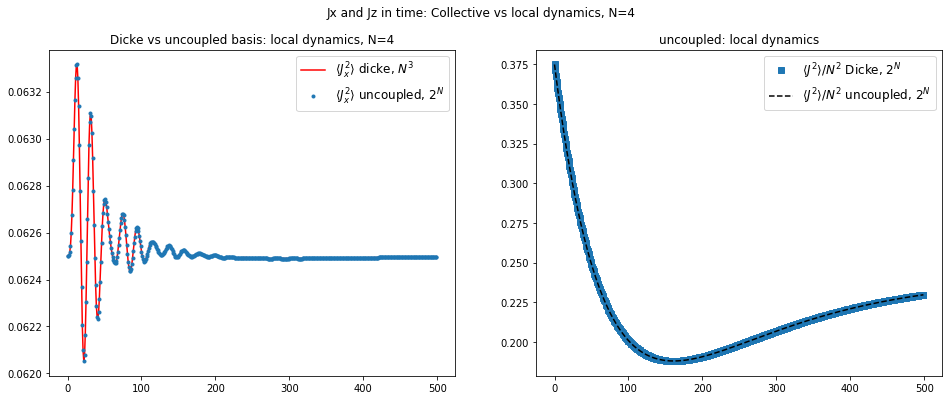

In [12]:
fs = 15 # font size
plt.figure(figsize=(16,6))
plt.subplot(121)
plt.title("Dicke vs uncoupled basis: local dynamics, N={}".format(N))
plt.plot(jxxt_local_dicke/N**2,"r-", label = "$\\langle J_x^2 \\rangle $ dicke, $N^3$")
plt.plot(jxxt_local_uncoupled/N**2,".", label = "$\\langle J_x^2 \\rangle $ uncoupled, $2^N$")
plt.legend(fontsize=fs*0.8)
plt.subplot(122)
plt.title("uncoupled: local dynamics")
plt.plot(j2t_local_dicke/N**2,"s", label = "$\\langle J^2 \\rangle/N^2 $ Dicke, $2^N$")
plt.plot(j2t_local_uncoupled/N**2,"k--", label = "$\\langle J^2 \\rangle/N^2 $ uncoupled, $2^N$")
plt.legend(fontsize=fs*0.8)
plt.suptitle("Jx and Jz in time: Collective vs local dynamics, N={}".format(N))
plt.show()
plt.close()

In the time plots above, we show how the solutions obtained from `mesolve` in the two formalisms match with each other. The Dicke basis calculations require only $N^3$ resources, whereas the uncoupled basis requires $ 2^N$ Hilbert spaces. 

## Efficiently calculating the Von Neumann Entropy in the Dicke basis

The Von Neumman entropy is a generalization of the Shannon entropy to quantum systems. It is also used in some cases as a witness of entanglement, for bipartite closed systems. Here we show that this nonlinear function of the density matrix can be calculated over the *representative* of the Dicke-basis density matrix, used above, by taking into account the correct weight of non-symmetrical subspaces of the total Hilbert space. 

A general function is defined to perform this weighted sum, `dicke_function_trace`, which is used by  `entropy_vn_dicke`, keeping the resources only polynomial with respect to the number of qubits or two-level systems.  

A check with respect to this function is performed below by using, for small $N$, the results from the uncoupled basis ($2^N$) and also by expanding, in a non-efficient way, the Dicke-basis density matrix into an object that is placed in the $2^N$ Hilbert space, by accounting explicitly for the degeneracy of each block of the density matrix in the Dicke formalism, using the function `dicke_blocks_full`. 

In [18]:
entropy_wrong = []
entropy_uncoupled = []
entropy_dicke = []
entropy_dicke_overhead = []
# uncoupled basis (2^N)
for i in range(len(rhot_local_uncoupled)):
    entropy_uncoupled.append(entropy_vn(rhot_local_uncoupled[i]))
# use density matrix calculated in the Dicke basis 
for i in range(len(rhot_local_dicke)):
    entropy_wrong.append(entropy_vn(rhot_local_dicke[i]) )
    entropy_dicke_overhead.append(entropy_vn(Qobj(block_diag(dicke_blocks_full(rhot_local_dicke[i])))))
    entropy_dicke.append(entropy_vn_dicke(rhot_local_dicke[i]))

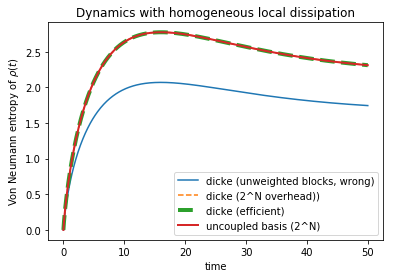

In [24]:
plt.figure()
plt.plot(times,entropy_wrong,"-",label="dicke (unweighted blocks, wrong)")
plt.plot(times,entropy_dicke_overhead,"--",label="dicke (2^N overhead))")
plt.plot(times,entropy_dicke,"--",linewidth = 4,label="dicke (efficient)")
plt.plot(times,entropy_uncoupled,linewidth = 2,label="uncoupled basis (2^N)")
plt.xlabel("time")
plt.ylabel("Von Neumann entropy of $\\rho(t)$")
plt.title("Dynamics with homogeneous local dissipation")
plt.legend()
plt.show()
plt.close()

As expected, there are three equivalent methods that can be used to calculate the Von Neumann entropy. 
By calculating it in a straightforward way from the *representative* of the density matrix in the Dicke basis formalism, the result is wrong, as it under-weighs the contribution from non-fully symmetric subspaces, corresponding to all the blocks on the right of the first block in the density matrix representation. 

Above, we use an efficient method to account for the Von Neumann entropy of the density matrix, using the `entropy_vn_dicke` function. This function applies the Von Neumann entropy function to each block of the density matrix, accounted with the correct degeneracy using the `dicke_function_trace` present in `qutip.piqs`. Similarly, in the next blocks the `purity_dicke` function will be calculated. 

### Purity of density matrices in the Dicke basis

In [20]:
purity_uncoupled = []
purity_dicke_list = []
purity_dicke_full = []
purity_wrong = []
for i in range(len(rhot_local_uncoupled)):
    # inefficient method
    purity_uncoupled.append((rhot_local_uncoupled[i]**2).tr())
for i in range(len(rhot_local_dicke)):
    # efficient method
    purity_dicke_list.append(purity_dicke(rhot_local_dicke[i]) )
    # inefficient method (scales with 2^N)
    rho_dicke_expanded = Qobj(block_diag(dicke_blocks_full(rhot_local_dicke[i])))
    purity_dicke_full.append((rho_dicke_expanded**2).tr())
    # wrong approach
    purity_wrong.append((rhot_local_dicke[i]**2).tr()) 

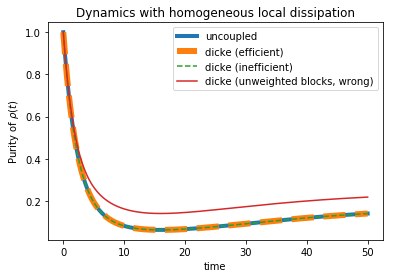

In [25]:
plt.plot()
plt.plot(times,purity_uncoupled,label="uncoupled", linewidth=4)
plt.plot(times,purity_dicke_list,"--",label="dicke (efficient)", linewidth=6)
plt.plot(times,purity_dicke_full,"--",label="dicke (inefficient)")
plt.plot(times,purity_wrong,"-",label="dicke (unweighted blocks, wrong)")
plt.xlabel("time")
plt.ylabel("Purity of $\\rho(t)$")
plt.legend()
plt.title("Dynamics with homogeneous local dissipation")
plt.show()
plt.close()

In the plot above we see that the three equivalent methods give the correct result. The user can define its own nonlinear functions, beyond entropy and purity, of the density matrix by using `dicke_function_trace`. 

In [22]:
qutip.about()


QuTiP: Quantum Toolbox in Python
Copyright (c) QuTiP team 2011 and later.
Original developers: R. J. Johansson & P. D. Nation.
Current admin team: Alexander Pitchford, Paul D. Nation, Nathan Shammah, Shahnawaz Ahmed, Neill Lambert, and Eric Giguère.
Project Manager: Franco Nori.
Currently developed through wide collaboration. See https://github.com/qutip for details.

QuTiP Version:      4.4.0
Numpy Version:      1.17.1
Scipy Version:      1.2.1
Cython Version:     0.29.8
Matplotlib Version: 3.0.3
Python Version:     3.7.3
Number of CPUs:     2
BLAS Info:          OPENBLAS
OPENMP Installed:   False
INTEL MKL Ext:      False
Platform Info:      Darwin (x86_64)
Installation path:  /miniconda3/lib/python3.7/site-packages/qutip
Please cite QuTiP in your publication.
For your convenience a bibtex reference can be easily generated using `qutip.cite()`


### References 
[1] N. Shammah, S. Ahmed, N. Lambert, S. De Liberato, and F. Nori, *Open quantum systems with local and collective incoherent processes: Efficient numerical simulation using permutational invariance", Phys. Rev. A **98**, 063815 (2018), https://arxiv.org/abs/1805.05129, https://journals.aps.org/pra/abstract/10.1103/PhysRevA.98.063815.

[2] L. Novo, T. Moroder, and O. Gühne, *Genuine multiparticle entanglement of permutationally invariant states*, Phys. Rev. A **88**, 012305 (2013). https://journals.aps.org/pra/abstract/10.1103/PhysRevA.88.012305